In [409]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm

In [410]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/arpafvg_fllbandiera_clean.csv', img_dir = 'data/images'):
        initial_data=pd.read_csv(weather_data)
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)

In [411]:
dataset = WeatherDataset()

In [412]:
#generate a list of strings dd-mm-yyyy from 01-06-2023 to 15-6-2024
from datetime import datetime, timedelta
start_date = datetime.strptime("01_06_2023", "%d_%m_%Y")
end_date = datetime.strptime("15_06_2024", "%d_%m_%Y")
date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
#transform the list of datetime objects in a list of strings in format dd-mm-yyyy
date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]


In [413]:
train_len = int(0.8 * len(date_generated))
test_len = len(date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]

In [414]:
(image, weather_data) = dataset[date_generated[np.random.randint(low = 0, high = len(dataset))]]
#print(weather_data)
#print(image)


In [415]:
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(6287, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, inputs):
        x1, x2 = inputs[0], inputs[1]
        

        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [416]:
def train(model, dataset, date_trainloader, date_testloader, criterion, optimizer, epochs, first_time = True, num_saved_epochs = 0):
    train_loss_epochs = []
    test_loss_epochs = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for date_inputs in tqdm(date_trainloader):
            inputs = dataset[date_inputs[0]]
            inputs = [inputs[0].float().unsqueeze(0), inputs[1].float().unsqueeze(0)]

            #increment of 1 day the date_inputs
            date_next_day = date_inputs[0].split('_')
            date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
            date_next_day = date_next_day.strftime("%d_%m_%Y")
            target=dataset[date_next_day][1][3].float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            #convert the loss type to float
            loss = loss.float()
            #print(f'loss is {loss}\n')
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date_inputs in tqdm(date_testloader):
            inputs = dataset[date_inputs[0]]
            inputs = [inputs[0].float().unsqueeze(0), inputs[1].float().unsqueeze(0)]
            outputs = model(inputs)

            #increment of 1 day the date_inputs
            date_next_day = date_inputs[0].split('_')
            date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
            date_next_day = date_next_day.strftime("%d_%m_%Y")
            target=dataset[date_next_day][1][3].float()

            loss = criterion(outputs.squeeze(), target)
            test_losses.append(loss.item())
        test_loss_epochs.append(np.mean(test_losses))
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")
        #if first_time:
            #torch.save(model.state_dict(), f"deepweather_epoch{num_saved_epochs + epoch + 1}.pth")

    return train_loss_epochs, test_loss_epochs

In [417]:
#Uncomment the lines below if you want to train/load a pretrained model
#num_saved_epochs = 50
#model = model.load_state_dict(torch.load(f'weights/epoch_{num_saved_epochs}'))

#Comment the (ONE) line below if you want to train/load a pretrained model.
#!mkdir weights
model = DeepWeather()

date_trainloader = DataLoader(date_trainset, batch_size = 1, shuffle = False)
date_testloader = DataLoader(date_testset, batch_size = 1, shuffle = False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 10e-6, momentum = 0)

In [418]:
train_losses, val_losses = train(model, dataset, date_trainloader, date_testloader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0)

  0%|          | 0/76 [00:00<?, ?it/s]/home/saradsai/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 76/76 [00:02<00:00, 26.22it/s]


Epoch 1/50, Train Loss: 2.497067938931319, Test Loss: 1.0802394401394657


100%|██████████| 76/76 [00:02<00:00, 27.04it/s]


Epoch 2/50, Train Loss: 1.516545442589246, Test Loss: 1.0940841931151226


100%|██████████| 76/76 [00:02<00:00, 26.78it/s]


Epoch 3/50, Train Loss: 1.342447345071158, Test Loss: 1.0836574608973406


100%|██████████| 76/76 [00:02<00:00, 27.22it/s]


Epoch 4/50, Train Loss: 1.2791690872875063, Test Loss: 1.0806481159182255


100%|██████████| 76/76 [00:02<00:00, 27.53it/s]


Epoch 5/50, Train Loss: 1.235336626806409, Test Loss: 1.0823004122419086


100%|██████████| 76/76 [00:02<00:00, 27.13it/s]


Epoch 6/50, Train Loss: 1.202063142910867, Test Loss: 1.0803600173216852


100%|██████████| 76/76 [00:02<00:00, 26.76it/s]


Epoch 7/50, Train Loss: 1.1837962258554358, Test Loss: 1.0906812152212584


100%|██████████| 76/76 [00:02<00:00, 27.75it/s]


Epoch 8/50, Train Loss: 1.1391485993889607, Test Loss: 1.0985078239019985


100%|██████████| 76/76 [00:02<00:00, 27.58it/s]


Epoch 9/50, Train Loss: 1.1104391121986934, Test Loss: 1.1012024714743205


100%|██████████| 76/76 [00:02<00:00, 27.94it/s]


Epoch 10/50, Train Loss: 1.10723798899362, Test Loss: 1.1026693508013665


100%|██████████| 76/76 [00:02<00:00, 25.98it/s]


Epoch 11/50, Train Loss: 1.0918564694816366, Test Loss: 1.1124611550577403


100%|██████████| 76/76 [00:02<00:00, 28.13it/s]


Epoch 12/50, Train Loss: 1.0865782839499458, Test Loss: 1.1034952930785948


100%|██████████| 76/76 [00:02<00:00, 28.55it/s]


Epoch 13/50, Train Loss: 1.0738897911613952, Test Loss: 1.1011801903077867


100%|██████████| 76/76 [00:02<00:00, 27.48it/s]


Epoch 14/50, Train Loss: 1.0586333750271322, Test Loss: 1.1099065113211461


100%|██████████| 76/76 [00:02<00:00, 27.75it/s]


Epoch 15/50, Train Loss: 1.0604244354236083, Test Loss: 1.1097860710835543


100%|██████████| 76/76 [00:02<00:00, 27.42it/s]


Epoch 16/50, Train Loss: 1.0547090809512936, Test Loss: 1.1126186102698117


100%|██████████| 76/76 [00:03<00:00, 25.25it/s]


Epoch 17/50, Train Loss: 1.0559819958022767, Test Loss: 1.0962077976039022


100%|██████████| 76/76 [00:04<00:00, 17.20it/s]


Epoch 18/50, Train Loss: 1.0491277236610395, Test Loss: 1.0949230428638035


100%|██████████| 76/76 [00:02<00:00, 32.55it/s]


Epoch 19/50, Train Loss: 1.047372115019752, Test Loss: 1.0948831917117594


100%|██████████| 76/76 [00:02<00:00, 28.38it/s]


Epoch 20/50, Train Loss: 1.032904976348737, Test Loss: 1.0780688466926989


100%|██████████| 76/76 [00:02<00:00, 32.15it/s]


Epoch 21/50, Train Loss: 1.0186161235560096, Test Loss: 1.0746992412540222


100%|██████████| 76/76 [00:02<00:00, 32.17it/s]


Epoch 22/50, Train Loss: 1.0098323211207236, Test Loss: 1.072518675263621


100%|██████████| 76/76 [00:02<00:00, 32.33it/s]


Epoch 23/50, Train Loss: 1.011658618647504, Test Loss: 1.0725485431576134


100%|██████████| 76/76 [00:02<00:00, 31.32it/s]


Epoch 24/50, Train Loss: 1.0113061600891102, Test Loss: 1.0721073916723214


100%|██████████| 76/76 [00:02<00:00, 29.59it/s]


Epoch 25/50, Train Loss: 1.0094242543596907, Test Loss: 1.0722859629183261


100%|██████████| 76/76 [00:02<00:00, 31.95it/s]


Epoch 26/50, Train Loss: 1.0146388180899426, Test Loss: 1.0742407572320907


100%|██████████| 76/76 [00:02<00:00, 30.88it/s]


Epoch 27/50, Train Loss: 1.0039164377530572, Test Loss: 1.0741140348928686


100%|██████████| 76/76 [00:02<00:00, 27.44it/s]


Epoch 28/50, Train Loss: 1.0090196560745066, Test Loss: 1.0735693995434543


100%|██████████| 76/76 [00:02<00:00, 31.73it/s]


Epoch 29/50, Train Loss: 1.0053181132441655, Test Loss: 1.075670832061549


100%|██████████| 76/76 [00:02<00:00, 32.76it/s]


Epoch 30/50, Train Loss: 1.0001949861023747, Test Loss: 1.0798420552432377


100%|██████████| 76/76 [00:02<00:00, 31.83it/s]


Epoch 31/50, Train Loss: 0.9964753056474843, Test Loss: 1.0793055433084526


100%|██████████| 76/76 [00:02<00:00, 32.59it/s]


Epoch 32/50, Train Loss: 0.9984919126647199, Test Loss: 1.0833119409201715


100%|██████████| 76/76 [00:02<00:00, 32.17it/s]


Epoch 33/50, Train Loss: 0.9924955223862669, Test Loss: 1.0839054264054682


100%|██████████| 76/76 [00:02<00:00, 31.40it/s]


Epoch 34/50, Train Loss: 0.9908365151528268, Test Loss: 1.0841980760328864


100%|██████████| 76/76 [00:02<00:00, 28.82it/s]


Epoch 35/50, Train Loss: 0.9902276573539356, Test Loss: 1.084232857729627


100%|██████████| 76/76 [00:02<00:00, 31.28it/s]


Epoch 36/50, Train Loss: 0.9914687028284263, Test Loss: 1.084140534852754


100%|██████████| 76/76 [00:02<00:00, 32.23it/s]


Epoch 37/50, Train Loss: 0.9922477942618911, Test Loss: 1.0838471722059981


100%|██████████| 76/76 [00:02<00:00, 30.95it/s]


Epoch 38/50, Train Loss: 0.9915452611931916, Test Loss: 1.0840133579423357


100%|██████████| 76/76 [00:02<00:00, 29.39it/s]


Epoch 39/50, Train Loss: 0.9906613804935492, Test Loss: 1.0842682859786834


100%|██████████| 76/76 [00:02<00:00, 32.01it/s]


Epoch 40/50, Train Loss: 0.9890271219420613, Test Loss: 1.0833967573003305


100%|██████████| 76/76 [00:02<00:00, 32.17it/s]


Epoch 41/50, Train Loss: 0.9881640977261046, Test Loss: 1.0837187603710365


100%|██████████| 76/76 [00:02<00:00, 31.66it/s]


Epoch 42/50, Train Loss: 0.9887792918862145, Test Loss: 1.0837151560086855


100%|██████████| 76/76 [00:02<00:00, 31.30it/s]


Epoch 43/50, Train Loss: 0.9870557820863005, Test Loss: 1.0825786373461597


100%|██████████| 76/76 [00:02<00:00, 27.50it/s]


Epoch 44/50, Train Loss: 0.9881538788826411, Test Loss: 1.0813062131009676


100%|██████████| 76/76 [00:02<00:00, 32.53it/s]


Epoch 45/50, Train Loss: 0.9885563102465369, Test Loss: 1.0827188255099922


100%|██████████| 76/76 [00:02<00:00, 30.95it/s]


Epoch 46/50, Train Loss: 0.990751198173755, Test Loss: 1.0822094480712334


100%|██████████| 76/76 [00:02<00:00, 31.75it/s]


Epoch 47/50, Train Loss: 0.9877381821075795, Test Loss: 1.0819063532858548


100%|██████████| 76/76 [00:02<00:00, 31.51it/s]


Epoch 48/50, Train Loss: 0.9871321486839616, Test Loss: 1.0797289974166473


100%|██████████| 76/76 [00:02<00:00, 32.14it/s]


Epoch 49/50, Train Loss: 0.9870530706589546, Test Loss: 1.0790148782160893


100%|██████████| 76/76 [00:02<00:00, 32.73it/s]

Epoch 50/50, Train Loss: 0.9854201798063729, Test Loss: 1.078952486101403


In [420]:
train_loss_epochs = [
    2.497067938931319,
    1.516545442589246,
    1.342447345071158,
    1.2791690872875063,
    1.235336626806409,
    1.202063142910867,
    1.1837962258554358,
    1.1391485993889607,
    1.1104391121986934,
    1.10723798899362,
    1.0918564694816366,
    1.0865782839499458,
    1.0738897911613952,
    1.0586333750271322,
    1.0604244354236083,
    1.0547090809512936,
    1.0559819958022767,
    1.0491277236610395,
    1.047372115019752,
    1.032904976348737,
    1.0186161235560096,
    1.0098323211207236,
    1.011658618647504,
    1.0113061600891102,
    1.0094242543596907,
    1.0146388180899426,
    1.0039164377530572,
    1.0090196560745066,
    1.0053181132441655,
    1.0001949861023747,
    0.9964753056474843,
    0.9984919126647199,
    0.9924955223862669,
    0.9908365151528268,
    0.9902276573539356,
    0.9914687028284263,
    0.9922477942618911,
    0.9915452611931916,
    0.9906613804935492,
    0.9890271219420613,
    0.9881640977261046,
    0.9887792918862145,
    0.9870557820863005,
    0.9881538788826411,
    0.9885563102465369,
    0.990751198173755,
    0.9877381821075795,
    0.9871321486839616,
    0.9870530706589546,
    0.9854201798063729
]

test_loss_epochs = [
    1.0802394401394657,
    1.0940841931151226,
    1.0836574608973406,
    1.0806481159182255,
    1.0823004122419086,
    1.0803600173216852,
    1.0906812152212584,
    1.0985078239019985,
    1.1012024714743205,
    1.1026693508013665,
    1.1124611550577403,
    1.1034952930785948,
    1.1011801903077867,
    1.1099065113211461,
    1.1097860710835543,
    1.1126186102698117,
    1.0962077976039022,
    1.0949230428638035,
    1.0948831917117594,
    1.0780688466926989,
    1.0746992412540222,
    1.072518675263621,
    1.0725485431576134,
    1.0721073916723214,
    1.0722859629183261,
    1.0742407572320907,
    1.0741140348928686,
    1.0735693995434543,
    1.075670832061549,
    1.0798420552432377,
    1.0793055433084526,
    1.0833119409201715,
    1.0839054264054682,
    1.0841980760328864,
    1.084232857729627,
    1.084140534852754,
    1.0838471722059981,
    1.0840133579423357,
    1.0842682859786834,
    1.0833967573003305,
    1.0837187603710365,
    1.0837151560086855,
    1.0825786373461597,
    1.0813062131009676,
    1.0827188255099922,
    1.0822094480712334,
    1.0819063532858548,
    1.0797289974166473,
    1.0790148782160893,
    1.078952486101403
]


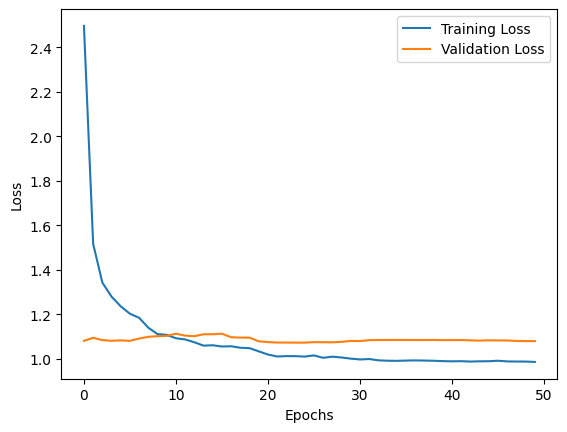

In [421]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_loss_epochs, label = 'Training Loss')
plt.plot(epochs, test_loss_epochs, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [432]:
def predict(model, date):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    inputs = dataset[date]
    inputs = [inputs[0].float().unsqueeze(0), inputs[1].float().unsqueeze(0)]

    outputs = model(inputs)    
    
    return outputs

In [450]:
print(predict(model, '31_12_2023'))
print(dataset['31_12_2023'][1][3])

tensor([[-0.0235]], grad_fn=<AddmmBackward0>)
tensor(-0.2589, dtype=torch.float64)


In [447]:
for date in date_testset:
    predicted_rain = predict(model, date)
    #non normalized results
    predicted_rain = predicted_rain 
    print(f"Predicted rain normalized for {date} is {predicted_rain}")
    #while real rain is
    print(f"Real rain normalized  for {date} is {dataset[date][1][3]}")   


Predicted rain normalized for 31_03_2024 is tensor([[-0.0237]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 31_03_2024 is -0.06831469270541114
Predicted rain normalized for 01_04_2024 is tensor([[-0.0254]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 01_04_2024 is 2.8909295153398413
Predicted rain normalized for 02_04_2024 is tensor([[-0.0291]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 02_04_2024 is -0.3709646685282211
Predicted rain normalized for 03_04_2024 is tensor([[-0.0259]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 03_04_2024 is -0.3709646685282211
Predicted rain normalized for 04_04_2024 is tensor([[-0.0275]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 04_04_2024 is -0.3709646685282211
Predicted rain normalized for 05_04_2024 is tensor([[-0.0271]], grad_fn=<AddmmBackward0>)
Real rain normalized  for 05_04_2024 is -0.3709646685282211
Predicted rain normalized for 06_04_2024 is tensor([[-0.0272]], grad_fn=<AddmmBackward0>)
Real rain 

In [ ]:
data = valset[np.random.randint(low = 0, high = len(valset))]

inputs = data[0]
inputs[0] = inputs[0].unsqueeze(0)
inputs[1] = inputs[1].unsqueeze(0)

label = (data[1] * dataset.labels_std) + dataset.labels_means
forecast = (inputs[1] * dataset.forecasts_std) + dataset.forecasts_means

prediction = predict(model, dataset, inputs)

forecast = forecast.squeeze()
prediction = prediction.squeeze()

print(f"Forecast:\n    Average Temp: {forecast[0]:.2f}K    Min Temp: {forecast[1]:.2f}K    Max Temp: {forecast[2]:.2f}K    Humidity: {forecast[4]:.2f}%    Clouds: {forecast[3]:.2f}%")
print(f"\nLabel:\n    Average Temp: {label[0]:.2f}K    Min Temp: {label[1]:.2f}K    Max Temp: {label[2]:.2f}K    Humidity: {label[3]:.2f}%")
print(f"\nPrediction:\n    Average Temp: {prediction[0]:.2f}K    Min Temp: {prediction[1]:.2f}K    Max Temp: {prediction[2]:.2f}K    Humidity: {prediction[3]:.2f}%")

In [ ]:
trainloader = DataLoader(trainset, batch_size = 128, shuffle = False)
train_r2 = 0
train_avg_temp_r2 = 0
train_min_temp_r2 = 0
train_max_temp_r2 = 0
train_humidity_r2 = 0
for i, data in enumerate(trainloader):
    inputs = data[0]
    labels = data[1]
    labels = (labels * dataset.labels_std) + dataset.labels_means
    
    outputs = predict(model, dataset, inputs)
    
    train_r2 += r2_score(labels, outputs)
    train_avg_temp_r2 += r2_score(labels[:, 0], outputs[:, 0])
    train_min_temp_r2 += r2_score(labels[:, 1], outputs[:, 1])
    train_max_temp_r2 += r2_score(labels[:, 2], outputs[:, 2])
    train_humidity_r2 += r2_score(labels[:, 3], outputs[:, 3])
    
train_r2 /= len(trainloader)
train_avg_temp_r2 /= len(trainloader)
train_min_temp_r2 /= len(trainloader)
train_max_temp_r2 /= len(trainloader)
train_humidity_r2 /= len(trainloader)

print("Training Data R2 Scores:")
print(f"    Avg Temp: {train_avg_temp_r2:.3f}")
print(f"    Min Temp: {train_min_temp_r2:.3f}")
print(f"    Max Temp: {train_max_temp_r2:.3f}")
print(f"    Humidity: {train_humidity_r2:.3f}")
print(f"    Total: {train_r2:.3f}")
    
    
    
    
valloader = DataLoader(valset, batch_size = 128, shuffle = False)
val_r2 = 0
val_avg_temp_r2 = 0
val_min_temp_r2 = 0
val_max_temp_r2 = 0
val_humidity_r2 = 0
for i, data in enumerate(valloader):
    inputs = data[0]
    labels = data[1]
    labels = (labels * dataset.labels_std) + dataset.labels_means
    
    outputs = predict(model, dataset, inputs)
    
    val_r2 += r2_score(labels, outputs)
    val_avg_temp_r2 += r2_score(labels[:, 0], outputs[:, 0])
    val_min_temp_r2 += r2_score(labels[:, 1], outputs[:, 1])
    val_max_temp_r2 += r2_score(labels[:, 2], outputs[:, 2])
    val_humidity_r2 += r2_score(labels[:, 3], outputs[:, 3])
    
val_r2 /= len(valloader)
val_avg_temp_r2 /= len(valloader)
val_min_temp_r2 /= len(valloader)
val_max_temp_r2 /= len(valloader)
val_humidity_r2 /= len(valloader)

print("\nValidation Data R2 Scores:")
print(f"    Avg Temp: {val_avg_temp_r2:.3f}")
print(f"    Min Temp: {val_min_temp_r2:.3f}")
print(f"    Max Temp: {val_max_temp_r2:.3f}")
print(f"    Humidity: {val_humidity_r2:.3f}")
print(f"    Total: {val_r2:.3f}")




dataloader = DataLoader(dataset, batch_size = 128)
forecast_r2 = 0
forecast_avg_temp_r2 = 0
forecast_min_temp_r2 = 0
forecast_max_temp_r2 = 0
forecast_humidity_r2 = 0
for i, data in enumerate(dataloader):
    inputs = data[0]
    labels = data[1]
    forecasts = inputs[1]
    forecasts = forecasts[:, np.r_[:3, 4]]
    
    forecast_avg_temp_r2 += r2_score(labels[:, 0], forecasts[:, 0])
    forecast_min_temp_r2 += r2_score(labels[:, 1], forecasts[:, 1])
    forecast_max_temp_r2 += r2_score(labels[:, 2], forecasts[:, 2])
    forecast_humidity_r2 += r2_score(labels[:, 3], forecasts[:, 3])
    forecast_r2 += r2_score(forecasts, labels)
    
forecast_r2 /= len(dataloader)
forecast_avg_temp_r2 /= len(dataloader)
forecast_min_temp_r2 /= len(dataloader)
forecast_max_temp_r2 /= len(dataloader)
forecast_humidity_r2 /= len(dataloader)

print("\nForecast Data R2 Scores:")
print(f"    Avg Temp: {forecast_avg_temp_r2:.3f}")
print(f"    Min Temp: {forecast_min_temp_r2:.3f}")
print(f"    Max Temp: {forecast_max_temp_r2:.3f}")
print(f"    Humidity: {forecast_humidity_r2:.3f}")
print(f"    Total: {forecast_r2:.3f}")